In [1]:

from dwdweather import DwdWeather
from datetime import datetime

# create client
dw = DwdWeather()

# Find closest station to position
closest = dw.nearest_station(lon=7, lat=51)

# The hour you're interested in.
# The example is 2014-03-22 12:00 (UTC).
query_hour = datetime(2014, 3, 22, 12)

result = dw.query(station_id=closest["station_id"], hour=query_hour)


ModuleNotFoundError: No module named 'dwdweather'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
measurement = pd.read_csv("../../windmeasurement.csv") 
forecast = pd.read_csv("../../windforecast.csv") 

In [66]:
from datetime import datetime

runhour = 19

def SelectRunHour(data, runhour):
    selection = data['runtime'].dt.hour == runhour
    data = data[selection]
    # Delete duplicates
    data = data.sort_values(by =['runtime'], ascending = False)  
    data = data.drop_duplicates('forecast_time',keep = 'first')  
    data = data.sort_values(by =['forecast_time'], ascending = False)  
    
    return data
    
def SelectRealForecast(data):
    posthoc = data['runtime'] < data['forecast_time']
    data = data[posthoc]
    return data

def SelectTimeRange(data, column, start_date, end_date):
    start_dates = data[column] > start_date
    end_dates = data[column] < end_date
    dates = start_dates & end_dates
    return data[dates]

def ResampleMean(data, column, time):
    data.index = data[column]
    data = data.resample(time).agg(['mean','max', 'min'])
    data[column] = data.index
    data.reset_index(drop=True, inplace=True)
    data.columns = ["_".join(x) for x in data.columns.ravel()]
    #data.columns = ['_'.join(col).strip() for col in data.columns.values]    

    for i,col in enumerate(data.columns):
        if col[-1] == "_":
            data.columns.values[i] = col[:-1]
    return data




In [67]:
measurement['runtime'] = pd.to_datetime(measurement['runtime'])
forecast['forecast_time'] = pd.to_datetime(forecast['forecast_time'])
forecast['runtime'] = pd.to_datetime(forecast['runtime'])

In [96]:
start_date = datetime(2018, 12, 11)
end_date = datetime(2018, 12, 16)
forecast_hour = 22


df_f = SelectRealForecast(forecast)
df_f = SelectTimeRange(df_f, 'forecast_time', start_date, end_date)
df_f = SelectRunHour(df_f,forecast_hour)

df_m = SelectTimeRange(measurement, 'runtime', start_date, end_date) 
df_m = ResampleMean(df_m, 'runtime', 'h')


df_m = df_m.add_prefix('m_')
df_f = df_f.add_prefix('f_')


In [97]:
print(df_m.head)

<bound method NDFrame.head of     m_wind_average_mean  m_wind_average_max  m_wind_average_min  \
0               1.69750               4.074               0.000   
1               2.06125               4.462               0.000   
2               2.15825               5.044               0.000   
3               1.60050               4.462               0.000   
4               1.64900               5.044               0.000   
5               1.47925               4.268               0.000   
6               2.18250               5.238               0.000   
7               1.40650               3.880               0.000   
8               1.45500               4.074               0.000   
9               1.21250               3.298               0.000   
10              1.09125               3.298               0.000   
11              1.89150               5.238               0.000   
12              2.44925               3.686               0.000   
13              2.32800         

## Measurement data

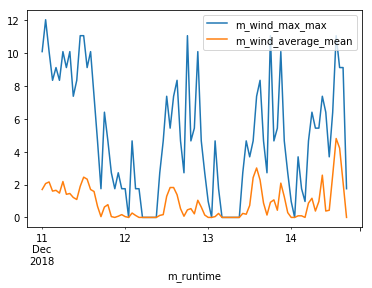

In [76]:
fig, ax = plt.subplots()

#measurement_hourly.plot(ax = ax, y = ['wind_max', 'wind_average']);
df_m.plot(ax = ax, x= 'm_runtime', y = 'm_wind_max_max');
df_m.plot(ax = ax, x= 'm_runtime', y = 'm_wind_average_mean');




##  Forecast Data

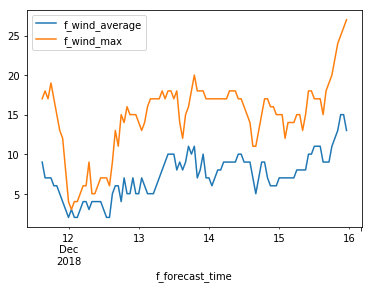

In [77]:
fig, ax = plt.subplots()
df_f.plot(ax = ax, x = 'f_forecast_time', y = 'f_wind_average');
df_f.plot(ax = ax, x = 'f_forecast_time', y = 'f_wind_max');

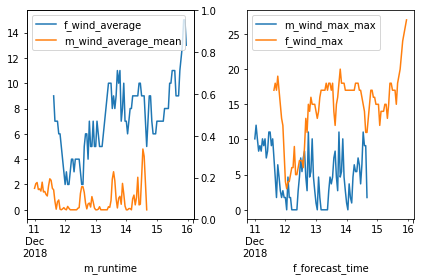

In [78]:
fig, ax = plt.subplots(1,2)
ax2 = ax[0].twinx()
#df_f['f_wind_average'] /=5.8023209459459455
df_f.plot(ax = ax[0], x = 'f_forecast_time', y = 'f_wind_average');
df_m.plot(ax = ax[0], x= 'm_runtime', y = 'm_wind_average_mean');
#df_f.plot(ax = ax2, x= 'f_forecast_time', y = 'f_wind_angle', color ='r');

#ax2 = ax[1].twinx()

df_m.plot(ax = ax[1], x= 'm_runtime', y = 'm_wind_max_max');
df_f.plot(ax = ax[1], x = 'f_forecast_time', y = 'f_wind_max');

plt.tight_layout()

NameError: name 'df_' is not defined

## Data analysis

In [99]:

f = pd.merge(df_m, df_f, left_on = 'm_runtime', right_on = 'f_forecast_time')
print(f.head)

<bound method NDFrame.head of Empty DataFrame
Columns: [m_wind_average_mean, m_wind_average_max, m_wind_average_min, m_wind_max_mean, m_wind_max_max, m_wind_max_min, m_runtime, f_runtime, f_forecast_time, f_wind_average, f_wind_max, f_wind_angle]
Index: []>


In [98]:
print(f['f_wind_average'].corr(f['m_wind_average_mean']))
print(f['f_wind_max'].corr(f['m_wind_max_max']))

0.42860869905853305
0.22279082977178963


In [95]:
print(f['f_wind_average'].corr(f['m_wind_average_mean']))
print(f['f_wind_max'].corr(f['m_wind_max_max']))

0.42860869905853305
0.22279082977178963


In [39]:
f['dif'] = f['m_wind_average_mean']-f['f_wind_average']

In [44]:
import numpy as np
print(np.average(f['dif']))

-5.8023209459459455


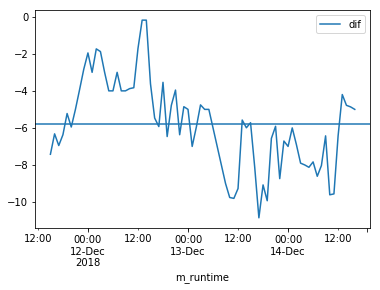

In [54]:
fig,ax = plt.subplots()
f.plot(ax = ax,x='m_runtime', y= 'dif')
ax.axhline(np.average(f['dif']))



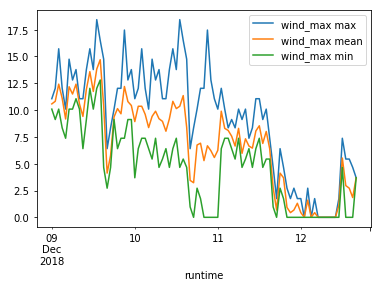

In [232]:
fig,ax = plt.subplots()
df_m.plot(ax = ax, x = 'runtime', y = 'wind_max max')
df_m.plot(ax = ax, x = 'runtime', y = 'wind_max mean')
df_m.plot(ax = ax, x = 'runtime', y = 'wind_max min')


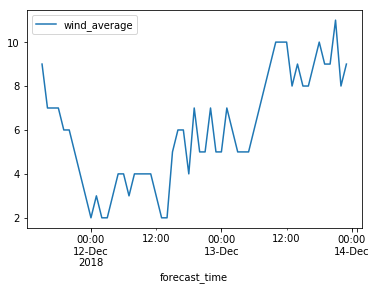

In [167]:
df1.plot(x = 'forecast_time', y= 'wind_average')

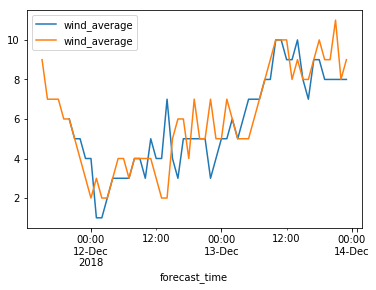

In [173]:
fig,ax = plt.subplots()
df2.plot(ax= ax,x = 'forecast_time', y= 'wind_average')
df1.plot(ax = ax, x = 'forecast_time', y= 'wind_average')

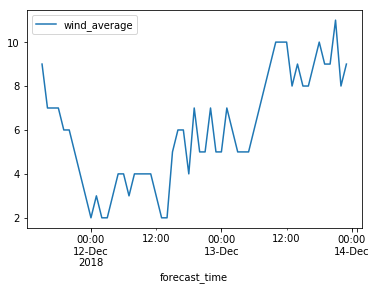

In [162]:
df.plot(x = 'forecast_time', y= 'wind_average')

In [112]:
measurement_hourly[dates];
forecast[posthoc]

,runtime,forecast_time,wind_average,wind_max,wind_angle
0,2018-12-12 14:40:00,2018-12-14 23:00:00,6.0,15.0,83.0
1,2018-12-12 14:40:00,2018-12-14 22:00:00,6.0,14.0,82.0
2,2018-12-12 14:40:00,2018-12-14 21:00:00,7.0,14.0,85.0
3,2018-12-12 14:40:00,2018-12-14 20:00:00,7.0,15.0,85.0
4,2018-12-12 14:40:00,2018-12-14 19:00:00,8.0,15.0,79.0
5,2018-12-12 14:40:00,2018-12-14 18:00:00,8.0,15.0,72.0
6,2018-12-12 14:40:00,2018-12-14 17:00:00,8.0,10.0,66.0
7,2018-12-12 14:40:00,2018-12-14 16:00:00,7.0,11.0,61.0
8,2018-12-12 14:40:00,2018-12-14 15:00:00,8.0,10.0,59.0
9,2018-12-12 14:40:00,2018-12-14 14:00:00,8.0,11.0,64.0


,runtime,forecast_time,wind_average,wind_max,wind_angle
0,2018-12-12 14:40:00,2018-12-14 23:00:00,6.0,15.0,83.0
37,2018-12-12 14:40:00,2018-12-13 10:00:00,10.0,18.0,87.0
54,2018-12-12 14:40:00,2018-12-12 17:00:00,6.0,11.0,51.0
52,2018-12-12 14:40:00,2018-12-12 19:00:00,7.0,14.0,52.0
51,2018-12-12 14:40:00,2018-12-12 20:00:00,5.0,16.0,66.0
50,2018-12-12 14:40:00,2018-12-12 21:00:00,5.0,15.0,47.0
49,2018-12-12 14:40:00,2018-12-12 22:00:00,7.0,15.0,66.0
48,2018-12-12 14:40:00,2018-12-12 23:00:00,5.0,15.0,72.0
47,2018-12-12 14:40:00,2018-12-13 00:00:00,5.0,14.0,76.0
46,2018-12-12 14:40:00,2018-12-13 01:00:00,7.0,13.0,84.0


In [121]:
forecast

,runtime,forecast_time,wind_average,wind_max,wind_angle
0,2018-12-12 14:40:00,2018-12-14 23:00:00,6.0,15.0,83.0
1,2018-12-12 14:40:00,2018-12-14 22:00:00,6.0,14.0,82.0
2,2018-12-12 14:40:00,2018-12-14 21:00:00,7.0,14.0,85.0
3,2018-12-12 14:40:00,2018-12-14 20:00:00,7.0,15.0,85.0
4,2018-12-12 14:40:00,2018-12-14 19:00:00,8.0,15.0,79.0
5,2018-12-12 14:40:00,2018-12-14 18:00:00,8.0,15.0,72.0
6,2018-12-12 14:40:00,2018-12-14 17:00:00,8.0,10.0,66.0
7,2018-12-12 14:40:00,2018-12-14 16:00:00,7.0,11.0,61.0
8,2018-12-12 14:40:00,2018-12-14 15:00:00,8.0,10.0,59.0
9,2018-12-12 14:40:00,2018-12-14 14:00:00,8.0,11.0,64.0


In [118]:
forecast.drop_duplicates('runtime')['runtime'].dt.hour

0       14
72      14
144     13
216     12
288      8
360      8
428      7
496      6
564      2
632      2
694      1
756      0
818     20
890     20
962     19
1034    18
1106    14
1178    14
1250    13
1322    12
1394     8
1466     8
1534     7
1602     6
1670     2
1738     2
1800     1
1862     0
1924    21
Name: runtime, dtype: int64